<a href="https://colab.research.google.com/github/liubruce11/BA820-TeamB7/blob/bruce-pet-cats/B1_Team07_BruceM3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Setup

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 120

In [6]:
# Load raw datasets
gps = pd.read_csv('cats_uk.csv')
ref = pd.read_csv('cats_uk_reference.csv')

print(f"GPS records: {gps.shape[0]:,}, Unique cats: {gps['tag_id'].nunique()}")
print(f"Reference table: {ref.shape[0]} cats, {ref.shape[1]} columns")
print(f"\nGPS columns: {list(gps.columns)}")
print(f"Reference columns: {list(ref.columns)}")

GPS records: 18,215, Unique cats: 101
Reference table: 101 cats, 16 columns

GPS columns: ['tag_id', 'event_id', 'visible', 'timestamp', 'location_long', 'location_lat', 'ground_speed', 'height_above_ellipsoid', 'algorithm_marked_outlier', 'manually_marked_outlier', 'study_name']
Reference columns: ['tag_id', 'animal_id', 'animal_taxon', 'deploy_on_date', 'deploy_off_date', 'hunt', 'prey_p_month', 'animal_reproductive_condition', 'animal_sex', 'hrs_indoors', 'n_cats', 'food_dry', 'food_wet', 'food_other', 'study_site', 'age_years']


In [7]:
# Clean GPS data (shared across all members)
gps['timestamp'] = pd.to_datetime(gps['timestamp'], utc=True, errors='coerce')
gps = gps.dropna(subset=['tag_id', 'timestamp', 'location_long', 'location_lat']).copy()
gps = gps.sort_values(['tag_id', 'timestamp']).reset_index(drop=True)

print(f"After cleaning: {gps.shape[0]:,} GPS records for {gps['tag_id'].nunique()} cats")

After cleaning: 18,215 GPS records for 101 cats


# Preprocessing

In [8]:
# Haversine distance function (from Bruce's M2, adopted as shared utility)
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Vectorized great-circle distance between two sets of points.
    Returns distance in meters.
    """
    R = 6371000  # Earth radius in meters
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2) ** 2
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

In [9]:
# Compute step distances between consecutive GPS points within each cat
gps['prev_lat'] = gps.groupby('tag_id')['location_lat'].shift(1)
gps['prev_lon'] = gps.groupby('tag_id')['location_long'].shift(1)
gps['prev_time'] = gps.groupby('tag_id')['timestamp'].shift(1)

mask = gps['prev_lat'].notna()
gps.loc[mask, 'step_distance_m'] = haversine_distance(
    gps.loc[mask, 'prev_lat'], gps.loc[mask, 'prev_lon'],
    gps.loc[mask, 'location_lat'], gps.loc[mask, 'location_long']
)
gps.loc[mask, 'time_diff_hrs'] = (
    (gps.loc[mask, 'timestamp'] - gps.loc[mask, 'prev_time']).dt.total_seconds() / 3600
)

print(f"Step distances computed: {gps['step_distance_m'].notna().sum():,} valid steps")

Step distances computed: 18,114 valid steps


In [10]:
# Radius of gyration (from Bruce's M2)
def radius_of_gyration(lats, lons):
    """RMS distance of all points from centroid, in meters."""
    if len(lats) == 0:
        return np.nan
    lat_mean = np.mean(lats)
    lon_mean = np.mean(lons)
    dists = haversine_distance(lats, lons, lat_mean, lon_mean)
    return np.sqrt(np.mean(dists ** 2))

In [13]:
# Build unified cat-level feature table
cat_features = gps.groupby('tag_id').apply(lambda g: pd.Series({
    # --- Tracking metadata ---
    'n_points': len(g),
    'tracking_hours': (
        (g['timestamp'].max() - g['timestamp'].min()).total_seconds() / 3600
        if len(g) > 1 else 0
    ),

    # --- Bruce's raw movement features ---
    'mean_step_m': g['step_distance_m'].mean(),
    'median_step_m': g['step_distance_m'].median(),
    'std_step_m': g['step_distance_m'].std(),
    'total_distance_m': g['step_distance_m'].sum(),
    'radius_of_gyration_m': radius_of_gyration(
        g['location_lat'].values, g['location_long'].values
    ),

    # --- Erica's spatial extent ---
    'bbox_area_deg2': (
        (g['location_long'].max() - g['location_long'].min()) *
        (g['location_lat'].max() - g['location_lat'].min())
    ),
    'lon_std': g['location_long'].std(),
    'lat_std': g['location_lat'].std(),

    # --- Emily's density-aware features ---
    'dist_per_point_m': (
        g['step_distance_m'].sum() / len(g) if len(g) > 0 else np.nan
    ),
    'bbox_area_per_point': (
        ((g['location_long'].max() - g['location_long'].min()) *
         (g['location_lat'].max() - g['location_lat'].min())) / len(g)
    ),
    'dist_per_hour': (
        g['step_distance_m'].sum() /
        ((g['timestamp'].max() - g['timestamp'].min()).total_seconds() / 3600)
        if len(g) > 1 and
           (g['timestamp'].max() - g['timestamp'].min()).total_seconds() > 0
        else np.nan
    ),
})).reset_index()

# Merge with reference data (household attributes for Allen/Erica)
cat_features = cat_features.merge(ref, on='tag_id', how='left')

print(f"Unified feature table: {cat_features.shape[0]} cats, {cat_features.shape[1]} columns")
cat_features[['tag_id', 'n_points', 'mean_step_m', 'median_step_m',
              'total_distance_m', 'radius_of_gyration_m',
              'dist_per_point_m', 'dist_per_hour']].describe().round(1)

Unified feature table: 101 cats, 29 columns


,n_points,mean_step_m,median_step_m,total_distance_m,radius_of_gyration_m,dist_per_point_m,dist_per_hour
count,101.0,101.0,101.0,101.0,101.0,101.0,101.0
mean,180.3,66.3,28.4,12377.8,225.9,65.7,87.8
std,146.3,82.0,9.2,21253.6,538.8,81.7,157.5
min,12.0,15.6,8.0,417.4,20.5,15.5,7.2
25%,100.0,35.1,22.1,4461.2,54.2,34.8,26.0
50%,155.0,43.6,26.8,6638.3,83.3,43.3,39.9
75%,214.0,62.6,32.9,11415.3,170.3,62.0,80.3
max,963.0,597.1,57.7,147252.0,4239.2,594.5,1047.8


## Integration: PCA Raw vs. Density-Aware

We run PCA on Bruce's raw features and Emily's density-aware features under identical standardization and on the same sample, enabling a controlled comparison.

**M2 Changes:** Bruce's PCA used only raw features. Emily compared separate PCAs on her own feature sets. Here both are run under identical conditions on the same 101 cats.

In [16]:
raw_features = ['mean_step_m', 'median_step_m', 'std_step_m',
                'total_distance_m', 'radius_of_gyration_m']

density_features = ['dist_per_point_m', 'dist_per_hour',
                    'radius_of_gyration_m', 'median_step_m']

In [17]:
# Prepare data — use all cats with complete features
cat_clean = cat_features.dropna(subset=raw_features + density_features).copy()
print(f"Cats with complete features: {cat_clean.shape[0]}")

# Standardize
scaler_raw = StandardScaler()
X_raw = scaler_raw.fit_transform(cat_clean[raw_features])

scaler_norm = StandardScaler()
X_norm = scaler_norm.fit_transform(cat_clean[density_features])

# Fit PCA
pca_raw = PCA()
scores_raw = pca_raw.fit_transform(X_raw)

pca_norm = PCA()
scores_norm = pca_norm.fit_transform(X_norm)

print(f"\nRAW PCA explained variance:          {np.round(pca_raw.explained_variance_ratio_, 3)}")
print(f"DENSITY-AWARE PCA explained variance: {np.round(pca_norm.explained_variance_ratio_, 3)}")

Cats with complete features: 101

RAW PCA explained variance:          [0.765 0.201 0.025 0.008 0.002]
DENSITY-AWARE PCA explained variance: [0.681 0.253 0.057 0.008]


In [18]:
# PC1 correlation with tracking density
raw_pc1_rho = pd.DataFrame({
    'PC1': scores_raw[:, 0],
    'n_points': cat_clean['n_points'].values
}).corr(method='spearman').iloc[0, 1]

norm_pc1_rho = pd.DataFrame({
    'PC1': scores_norm[:, 0],
    'n_points': cat_clean['n_points'].values
}).corr(method='spearman').iloc[0, 1]

print(f"RAW PC1 <-> n_points (Spearman):          rho = {raw_pc1_rho:.3f}")
print(f"DENSITY-AWARE PC1 <-> n_points (Spearman): rho = {norm_pc1_rho:.3f}")

RAW PC1 <-> n_points (Spearman):          rho = 0.472
DENSITY-AWARE PC1 <-> n_points (Spearman): rho = 0.499


In [19]:
# PCA Loadings
print("RAW PCA Loadings (PC1, PC2):")
raw_loadings = pd.DataFrame(
    pca_raw.components_[:2].T,
    index=raw_features, columns=['PC1', 'PC2']
)
print(raw_loadings.round(3))

print("\nDENSITY-AWARE PCA Loadings (PC1, PC2):")
norm_loadings = pd.DataFrame(
    pca_norm.components_[:2].T,
    index=density_features, columns=['PC1', 'PC2']
)
print(norm_loadings.round(3))

print("\nKey insight: median_step_m loads almost exclusively on PC2 in both")
print("representations, confirming it captures distinct information.")

RAW PCA Loadings (PC1, PC2):
                        PC1    PC2
mean_step_m           0.498  0.057
median_step_m        -0.023  0.997
std_step_m            0.505 -0.039
total_distance_m      0.488  0.008
radius_of_gyration_m  0.508  0.019

DENSITY-AWARE PCA Loadings (PC1, PC2):
                        PC1    PC2
dist_per_point_m      0.585  0.102
dist_per_hour         0.554 -0.089
radius_of_gyration_m  0.591  0.063
median_step_m        -0.048  0.989

Key insight: median_step_m loads almost exclusively on PC2 in both
representations, confirming it captures distinct information.


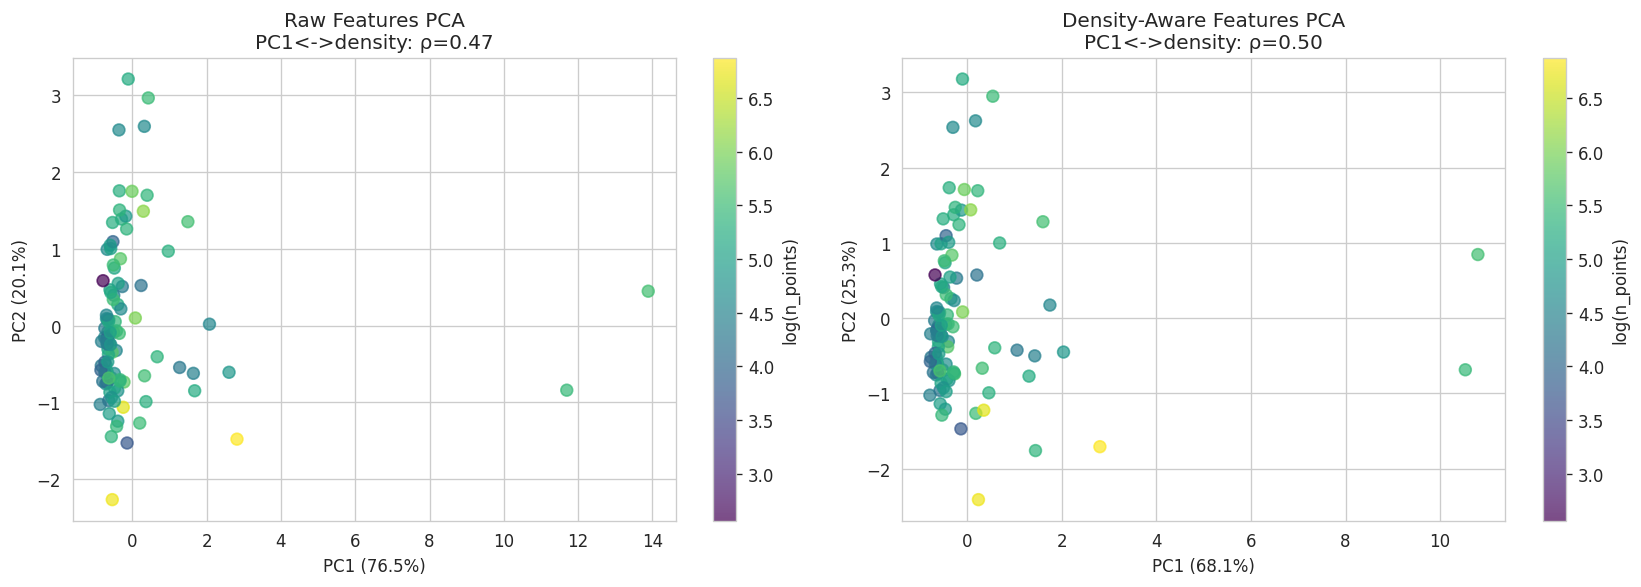

In [20]:
# PCA scatter plots — Figure for report
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sc1 = axes[0].scatter(
    scores_raw[:, 0], scores_raw[:, 1],
    c=np.log1p(cat_clean['n_points']), cmap='viridis', alpha=0.7, s=50
)
axes[0].set_xlabel(f"PC1 ({pca_raw.explained_variance_ratio_[0]:.1%})")
axes[0].set_ylabel(f"PC2 ({pca_raw.explained_variance_ratio_[1]:.1%})")
axes[0].set_title(f'Raw Features PCA\nPC1<->density: ρ={raw_pc1_rho:.2f}')
plt.colorbar(sc1, ax=axes[0], label='log(n_points)')

sc2 = axes[1].scatter(
    scores_norm[:, 0], scores_norm[:, 1],
    c=np.log1p(cat_clean['n_points']), cmap='viridis', alpha=0.7, s=50
)
axes[1].set_xlabel(f"PC1 ({pca_norm.explained_variance_ratio_[0]:.1%})")
axes[1].set_ylabel(f"PC2 ({pca_norm.explained_variance_ratio_[1]:.1%})")
axes[1].set_title(f'Density-Aware Features PCA\nPC1<->density: ρ={norm_pc1_rho:.2f}')
plt.colorbar(sc2, ax=axes[1], label='log(n_points)')

plt.tight_layout()
plt.savefig('fig_pca_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Integration: Clustering Stability

We (Bruce, Emily, and Erica) each independently found that clustering produces no stable behavioral types. We tested K-Means at k=2,3,4 on both raw and density-aware features.

**M2 Changes:** Each member tested clustering on different features with different k. Here we compare all k values on both feature sets under identical conditions.

In [23]:
# Clustering comparison
print(f"{'Feature Set':<20} {'k':>3} {'Silhouette':>12} {'Cluster Sizes'}")
print("-" * 65)

for label, X_data in [("RAW", X_raw), ("DENSITY-AWARE", X_norm)]:
    for k in [2, 3, 4]:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X_data)
        sil = silhouette_score(X_data, labels)
        sizes = sorted(pd.Series(labels).value_counts().values, reverse=True)
        print(f"{label:<20} {k:>3} {sil:>12.3f}   {sizes}")

Feature Set            k   Silhouette Cluster Sizes
-----------------------------------------------------------------
RAW                    2        0.880   [np.int64(99), np.int64(2)]
RAW                    3        0.470   [np.int64(73), np.int64(26), np.int64(2)]
RAW                    4        0.528   [np.int64(67), np.int64(26), np.int64(6), np.int64(2)]
DENSITY-AWARE          2        0.858   [np.int64(99), np.int64(2)]
DENSITY-AWARE          3        0.467   [np.int64(73), np.int64(26), np.int64(2)]
DENSITY-AWARE          4        0.504   [np.int64(63), np.int64(23), np.int64(13), np.int64(2)]


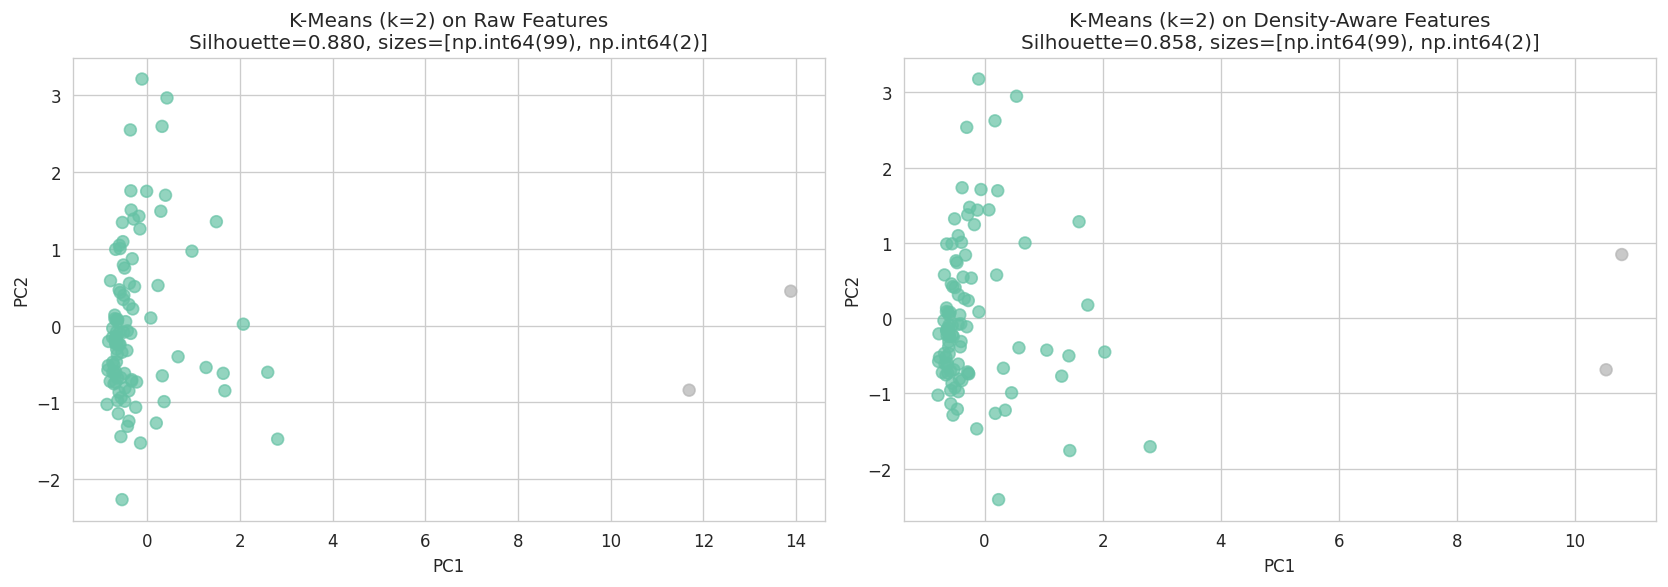


Key finding: Both feature sets produce identical structure —
99 cats in main cluster, 2 extreme outliers.
Behavioral variation is continuous, not categorical.


In [24]:
# Clustering visualization — Figure for report
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

km_raw = KMeans(n_clusters=2, random_state=42, n_init=10).fit_predict(X_raw)
sil_raw = silhouette_score(X_raw, km_raw)
axes[0].scatter(scores_raw[:, 0], scores_raw[:, 1], c=km_raw, cmap='Set2', alpha=0.7, s=50)
axes[0].set_xlabel('PC1'); axes[0].set_ylabel('PC2')
sizes_raw = sorted(pd.Series(km_raw).value_counts().values, reverse=True)
axes[0].set_title(f'K-Means (k=2) on Raw Features\nSilhouette={sil_raw:.3f}, sizes={sizes_raw}')

km_norm = KMeans(n_clusters=2, random_state=42, n_init=10).fit_predict(X_norm)
sil_norm = silhouette_score(X_norm, km_norm)
axes[1].scatter(scores_norm[:, 0], scores_norm[:, 1], c=km_norm, cmap='Set2', alpha=0.7, s=50)
axes[1].set_xlabel('PC1'); axes[1].set_ylabel('PC2')
sizes_norm = sorted(pd.Series(km_norm).value_counts().values, reverse=True)
axes[1].set_title(f'K-Means (k=2) on Density-Aware Features\nSilhouette={sil_norm:.3f}, sizes={sizes_norm}')

plt.tight_layout()
plt.savefig('fig_clustering_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nKey finding: Both feature sets produce identical structure —")
print("99 cats in main cluster, 2 extreme outliers.")
print("Behavioral variation is continuous, not categorical.")